$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw4/answers.py`.

In [2]:
import cs236781.plot as plot
import cs236781.download
from hw4.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /Users/romy/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /Users/romy/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /Users/romy/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


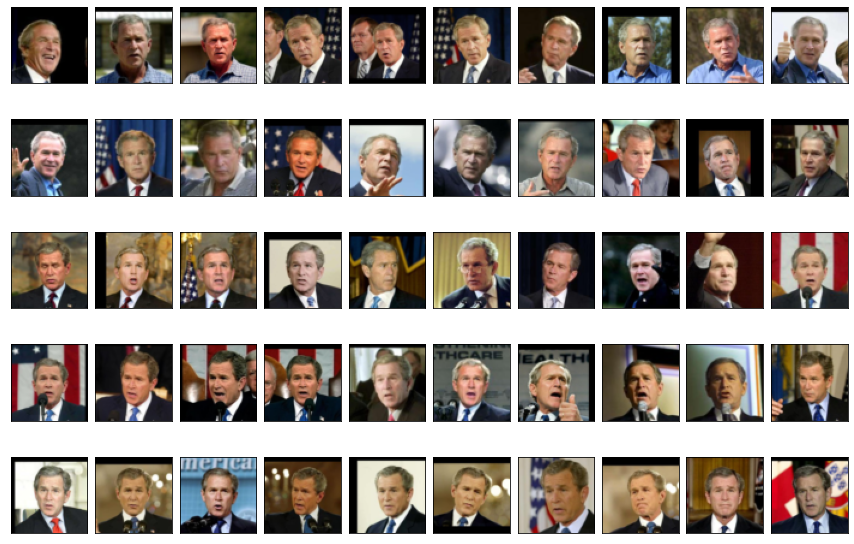

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw4/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw4.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(16, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=25, out_features=1, bias=True)
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw4/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
  (projection): Sequential(
    (0): Linear(in_features=128, out_features=16384, bias=True)
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw4/gan.py` module.

In [48]:
from hw4.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw4/gan.py` module.

In [49]:
from hw4.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw4/gan.py` module.

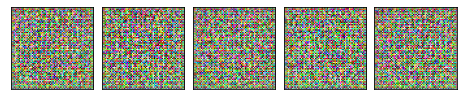

In [50]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw4/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw4/answers.py` module.

In [52]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw4.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 4, 'z_dim': 512, 'data_label': 0, 'label_noise': 0.4, 'discriminator_optimizer': {'type': 'SGD', 'lr': 0.001}, 'generator_optimizer': {'type': 'SGD', 'lr': 0.001}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw4.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|█████████████████████████████████████████| 133/133 [00:35<00:00,  3.76it/s]
Discriminator loss: 0.6821329826979261
Generator loss:     1.8489230942905397


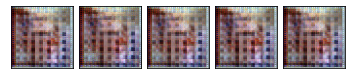

--- EPOCH 2/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.21it/s]
Discriminator loss: 0.9787159540263334
Generator loss:     1.7894074790235748


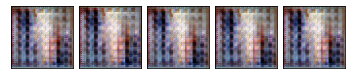

--- EPOCH 3/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.42it/s]
Discriminator loss: 0.6928870370681572
Generator loss:     2.506305804826263


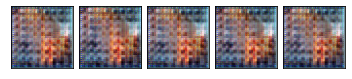

--- EPOCH 4/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.74it/s]
Discriminator loss: 0.5519188012843742
Generator loss:     2.5723858524982193


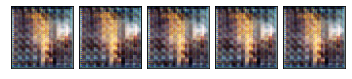

--- EPOCH 5/100 ---
100%|█████████████████████████████████████████| 133/133 [00:27<00:00,  4.77it/s]
Discriminator loss: 0.767832632127561
Generator loss:     1.9474162123257057


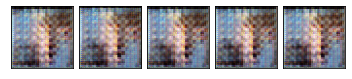

--- EPOCH 6/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.71it/s]
Discriminator loss: 0.8581867830869847
Generator loss:     2.797990153606673


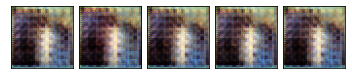

--- EPOCH 7/100 ---
100%|█████████████████████████████████████████| 133/133 [00:27<00:00,  4.77it/s]
Discriminator loss: 0.9751684881354633
Generator loss:     1.9652120731000726


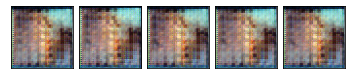

--- EPOCH 8/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.75it/s]
Discriminator loss: 0.9777993391779133
Generator loss:     1.9243252561952835


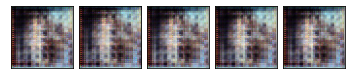

--- EPOCH 9/100 ---
100%|█████████████████████████████████████████| 133/133 [00:27<00:00,  4.77it/s]
Discriminator loss: 0.6979899937497046
Generator loss:     2.468367678330357


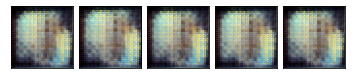

--- EPOCH 10/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.49it/s]
Discriminator loss: 0.7536196662183094
Generator loss:     1.902178474386832


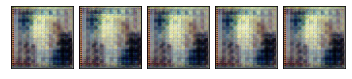

--- EPOCH 11/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.12it/s]
Discriminator loss: 0.6916588183240335
Generator loss:     2.2382241590578755


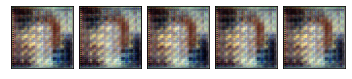

--- EPOCH 12/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.09it/s]
Discriminator loss: 0.7795709560912355
Generator loss:     1.549610149591489


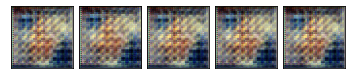

--- EPOCH 13/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.55it/s]
Discriminator loss: 0.8647244681317107
Generator loss:     1.6134326753759742


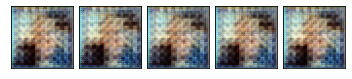

--- EPOCH 14/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.58it/s]
Discriminator loss: 0.7055448431213548
Generator loss:     2.1001219574670147


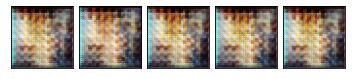

--- EPOCH 15/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.19it/s]
Discriminator loss: 0.9230645106811273
Generator loss:     2.0527003261827885


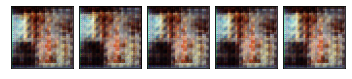

--- EPOCH 16/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.33it/s]
Discriminator loss: 0.5027352522890595
Generator loss:     2.0700878281342354


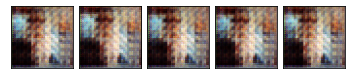

--- EPOCH 17/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.23it/s]
Discriminator loss: 0.39566697975746673
Generator loss:     2.0673252971548783


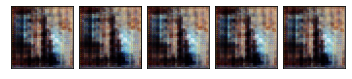

--- EPOCH 18/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.08it/s]
Discriminator loss: 0.34539546265750004
Generator loss:     2.8338239946423616


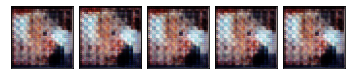

--- EPOCH 19/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.44it/s]
Discriminator loss: 0.8214857892546439
Generator loss:     1.7893252455650415


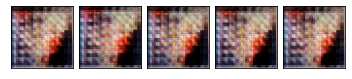

--- EPOCH 20/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.38it/s]
Discriminator loss: 0.5299493345270928
Generator loss:     2.310078882633295


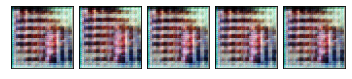

--- EPOCH 21/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  3.99it/s]
Discriminator loss: 1.0348969974127926
Generator loss:     2.6449587434194144


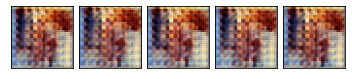

--- EPOCH 22/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.06it/s]
Discriminator loss: 0.8937514108374602
Generator loss:     1.9843596569577555


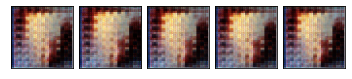

--- EPOCH 23/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.10it/s]
Discriminator loss: 1.0036914944648743
Generator loss:     1.762559317556539


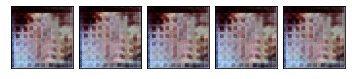

--- EPOCH 24/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.05it/s]
Discriminator loss: 0.5608146357581132
Generator loss:     2.0757674346292827


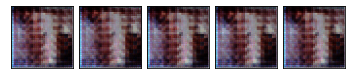

--- EPOCH 25/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  4.01it/s]
Discriminator loss: 0.9881414086242816
Generator loss:     1.6004968567898399


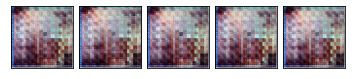

--- EPOCH 26/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.03it/s]
Discriminator loss: 0.799575842580849
Generator loss:     1.9105222063853329


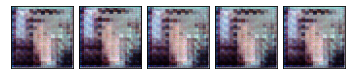

--- EPOCH 27/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.25it/s]
Discriminator loss: 0.89699326746894
Generator loss:     2.260019956954888


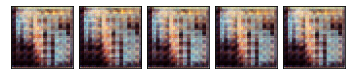

--- EPOCH 28/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.15it/s]
Discriminator loss: 0.7882111567191612
Generator loss:     1.639229747137629


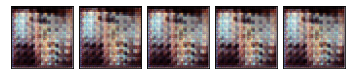

--- EPOCH 29/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.31it/s]
Discriminator loss: 0.8262098881423026
Generator loss:     1.7612489264710505


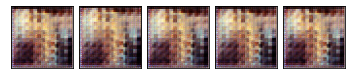

--- EPOCH 30/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.74it/s]
Discriminator loss: 0.6681586458606827
Generator loss:     1.715661092360217


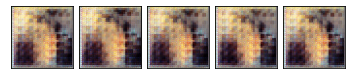

--- EPOCH 31/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.26it/s]
Discriminator loss: 0.7327044597805891
Generator loss:     1.722977436574778


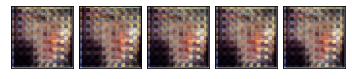

--- EPOCH 32/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  3.99it/s]
Discriminator loss: 0.926607791586478
Generator loss:     2.291618876439288


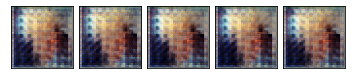

--- EPOCH 33/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.04it/s]
Discriminator loss: 0.931322119289771
Generator loss:     1.6067675193001454


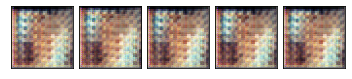

--- EPOCH 34/100 ---
100%|█████████████████████████████████████████| 133/133 [00:27<00:00,  4.79it/s]
Discriminator loss: 0.8902466583408808
Generator loss:     2.003739982843399


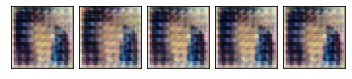

--- EPOCH 35/100 ---
100%|█████████████████████████████████████████| 133/133 [00:36<00:00,  3.66it/s]
Discriminator loss: 0.49923603466354816
Generator loss:     1.9763710023765277


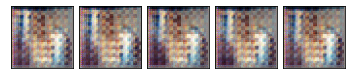

--- EPOCH 36/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  3.97it/s]
Discriminator loss: 0.7722720523974053
Generator loss:     1.4585575416572112


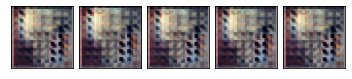

--- EPOCH 37/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.09it/s]
Discriminator loss: 0.8772367283813935
Generator loss:     2.1231157313612172


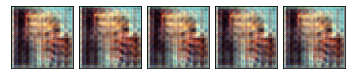

--- EPOCH 38/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  4.03it/s]
Discriminator loss: 0.8188569858894312
Generator loss:     1.8514264351443241


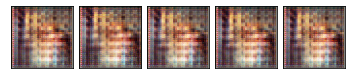

--- EPOCH 39/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.09it/s]
Discriminator loss: 0.7085909739248735
Generator loss:     2.5695826890773343


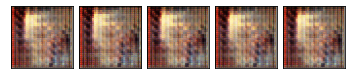

--- EPOCH 40/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.18it/s]
Discriminator loss: 0.4805105621261256
Generator loss:     2.808927491643375


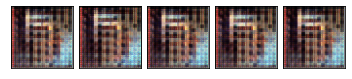

--- EPOCH 41/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.53it/s]
Discriminator loss: 0.4621019394213992
Generator loss:     3.7923932093426695


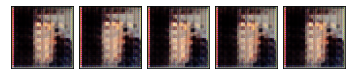

--- EPOCH 42/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.24it/s]
Discriminator loss: 0.40014450383701716
Generator loss:     3.8310642327581133


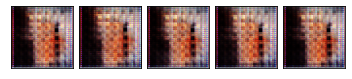

--- EPOCH 43/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.10it/s]
Discriminator loss: 0.6660939272969288
Generator loss:     1.8899354293830413


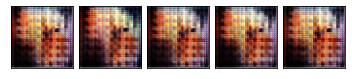

--- EPOCH 44/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.07it/s]
Discriminator loss: 0.6094025182432699
Generator loss:     1.9718919055802482


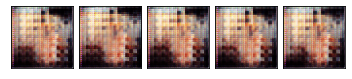

--- EPOCH 45/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.10it/s]
Discriminator loss: 0.47610337788561236
Generator loss:     1.9884156607147445


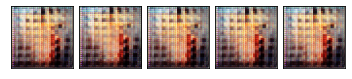

--- EPOCH 46/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.10it/s]
Discriminator loss: 0.8566046342029607
Generator loss:     2.1212142217428163


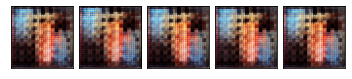

--- EPOCH 47/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.59it/s]
Discriminator loss: 0.9760543407130062
Generator loss:     1.3164318432485251


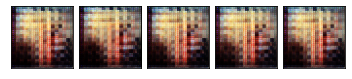

--- EPOCH 48/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.27it/s]
Discriminator loss: 0.9801743064159737
Generator loss:     1.3213028476426476


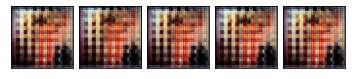

--- EPOCH 49/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.35it/s]
Discriminator loss: 0.8951651948062997
Generator loss:     1.6390107207952584


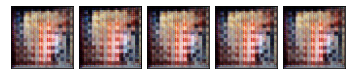

--- EPOCH 50/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.69it/s]
Discriminator loss: 1.0266781773670275
Generator loss:     2.0160780428047467


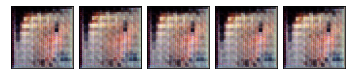

--- EPOCH 51/100 ---
100%|█████████████████████████████████████████| 133/133 [00:27<00:00,  4.75it/s]
Discriminator loss: 1.0426481470913815
Generator loss:     1.8202944590633077


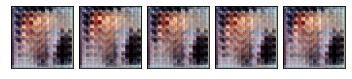

--- EPOCH 52/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.74it/s]
Discriminator loss: 0.6104557102728159
Generator loss:     1.9941937874134321


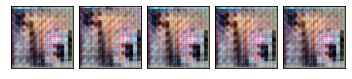

--- EPOCH 53/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.74it/s]
Discriminator loss: 0.6986851866980245
Generator loss:     1.9818913479496663


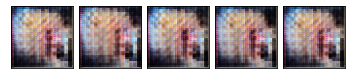

--- EPOCH 54/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.74it/s]
Discriminator loss: 0.49411086046269964
Generator loss:     2.273608029785013


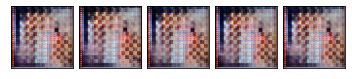

--- EPOCH 55/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.74it/s]
Discriminator loss: 0.8345268567029694
Generator loss:     1.3951097363816167


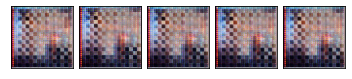

--- EPOCH 56/100 ---
100%|█████████████████████████████████████████| 133/133 [00:27<00:00,  4.76it/s]
Discriminator loss: 1.0721839673088907
Generator loss:     1.8361814319807337


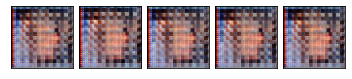

--- EPOCH 57/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.70it/s]
Discriminator loss: 0.9352990584658053
Generator loss:     1.7684358430088014


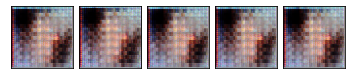

--- EPOCH 58/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.68it/s]
Discriminator loss: 0.8157261372508859
Generator loss:     1.8120511640283399


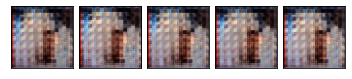

--- EPOCH 59/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.09it/s]
Discriminator loss: 0.9113818086907828
Generator loss:     1.720510068888727


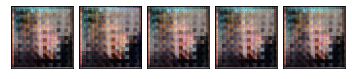

--- EPOCH 60/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.39it/s]
Discriminator loss: 0.9573576955642915
Generator loss:     1.6368104725291854


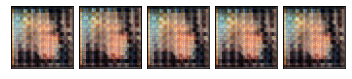

--- EPOCH 61/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.42it/s]
Discriminator loss: 0.9282460936478206
Generator loss:     1.451784869333855


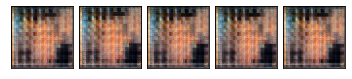

--- EPOCH 62/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.20it/s]
Discriminator loss: 0.8328404025475782
Generator loss:     1.4985586082128655


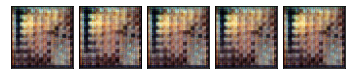

--- EPOCH 63/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.58it/s]
Discriminator loss: 0.6862976851039811
Generator loss:     1.996217638030088


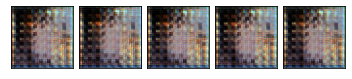

--- EPOCH 64/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.74it/s]
Discriminator loss: 0.3688782018266226
Generator loss:     2.3519364434077326


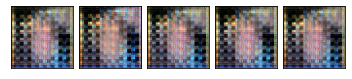

--- EPOCH 65/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.75it/s]
Discriminator loss: 0.5875328192977529
Generator loss:     2.130823134479666


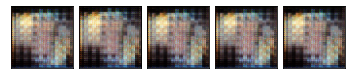

--- EPOCH 66/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.67it/s]
Discriminator loss: 1.0563576434339796
Generator loss:     1.4553067684173584


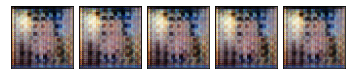

--- EPOCH 67/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.36it/s]
Discriminator loss: 0.5798994810285425
Generator loss:     1.901036630895801


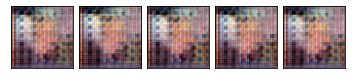

--- EPOCH 68/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.15it/s]
Discriminator loss: 0.8199816251495727
Generator loss:     1.8408404875518685


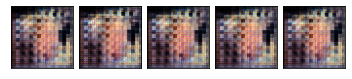

--- EPOCH 69/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.26it/s]
Discriminator loss: 0.5078411699461758
Generator loss:     1.8301041108325011


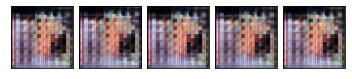

--- EPOCH 70/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.24it/s]
Discriminator loss: 0.4774879866972902
Generator loss:     2.3653913095481416


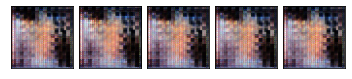

--- EPOCH 71/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.43it/s]
Discriminator loss: 0.6398338053123396
Generator loss:     2.0173568147465697


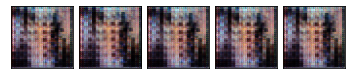

--- EPOCH 72/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.31it/s]
Discriminator loss: 0.9435703244088287
Generator loss:     3.038180101522826


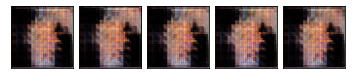

--- EPOCH 73/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.45it/s]
Discriminator loss: 0.6785767566608755
Generator loss:     2.009866478229712


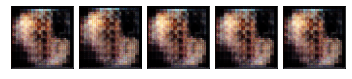

--- EPOCH 74/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.29it/s]
Discriminator loss: 0.7082950591872957
Generator loss:     1.8788259644481473


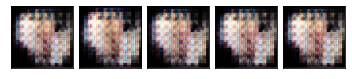

--- EPOCH 75/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.26it/s]
Discriminator loss: 0.6434072397817346
Generator loss:     1.742340814798398


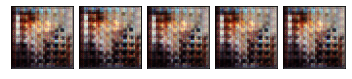

--- EPOCH 76/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.10it/s]
Discriminator loss: 0.6731063973410685
Generator loss:     1.5039393202702802


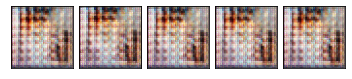

--- EPOCH 77/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.33it/s]
Discriminator loss: 0.8650560940342739
Generator loss:     1.9093682591180157


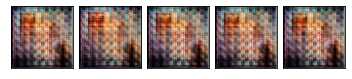

--- EPOCH 78/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.16it/s]
Discriminator loss: 1.2519118823671251
Generator loss:     1.565216311050537


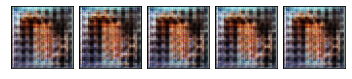

--- EPOCH 79/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.23it/s]
Discriminator loss: 0.5515303663853416
Generator loss:     1.844368806907109


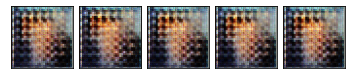

--- EPOCH 80/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.08it/s]
Discriminator loss: 0.9270626661136634
Generator loss:     1.8864386956158437


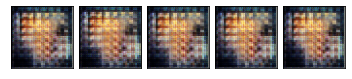

--- EPOCH 81/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  3.98it/s]
Discriminator loss: 1.0031873843163477
Generator loss:     1.5902665687682933


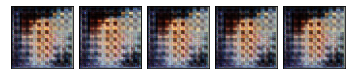

--- EPOCH 82/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.58it/s]
Discriminator loss: 0.9208235797801412
Generator loss:     1.5717596250369137


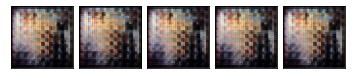

--- EPOCH 83/100 ---
100%|█████████████████████████████████████████| 133/133 [00:32<00:00,  4.09it/s]
Discriminator loss: 0.6906554600349942
Generator loss:     1.7254470400792314


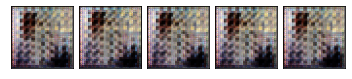

--- EPOCH 84/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.28it/s]
Discriminator loss: 0.5366806226565426
Generator loss:     2.12415122223976


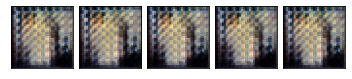

--- EPOCH 85/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.29it/s]
Discriminator loss: 1.0025224170290439
Generator loss:     2.0271819164430287


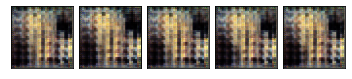

--- EPOCH 86/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.70it/s]
Discriminator loss: 0.7507172129432061
Generator loss:     2.231112014082141


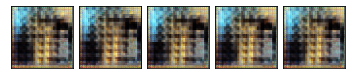

--- EPOCH 87/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.16it/s]
Discriminator loss: 0.543456205804097
Generator loss:     2.147118097857425


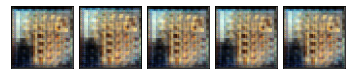

--- EPOCH 88/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.46it/s]
Discriminator loss: 0.7881359512308487
Generator loss:     2.141830027775657


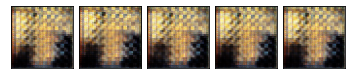

--- EPOCH 89/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.25it/s]
Discriminator loss: 0.7332676483276195
Generator loss:     2.0810922680044532


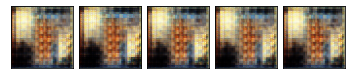

--- EPOCH 90/100 ---
100%|█████████████████████████████████████████| 133/133 [00:31<00:00,  4.27it/s]
Discriminator loss: 0.6722333013619247
Generator loss:     1.868228562792441


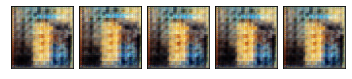

--- EPOCH 91/100 ---
100%|█████████████████████████████████████████| 133/133 [00:33<00:00,  3.96it/s]
Discriminator loss: 0.6711481497868111
Generator loss:     1.887953715665


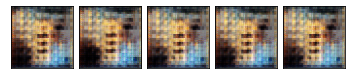

--- EPOCH 92/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.31it/s]
Discriminator loss: 0.7467432763231429
Generator loss:     1.835423828067636


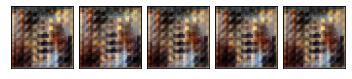

--- EPOCH 93/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.63it/s]
Discriminator loss: 0.6826815278010261
Generator loss:     2.1070197569696525


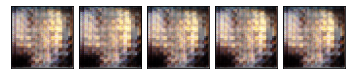

--- EPOCH 94/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.64it/s]
Discriminator loss: 0.6383352740702772
Generator loss:     1.7032304787098016


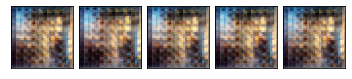

--- EPOCH 95/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.60it/s]
Discriminator loss: 0.6640718448767089
Generator loss:     1.9283530595607328


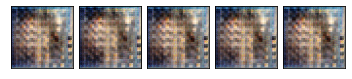

--- EPOCH 96/100 ---
100%|█████████████████████████████████████████| 133/133 [00:30<00:00,  4.34it/s]
Discriminator loss: 0.7757287505537944
Generator loss:     1.9219551095388885


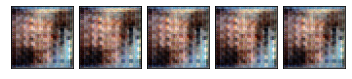

--- EPOCH 97/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.54it/s]
Discriminator loss: 0.9147846120920845
Generator loss:     2.136049448995662


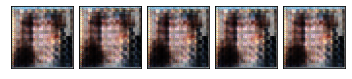

--- EPOCH 98/100 ---
100%|█████████████████████████████████████████| 133/133 [00:27<00:00,  4.81it/s]
Discriminator loss: 0.7688755384065155
Generator loss:     1.504275379772473


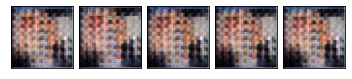

--- EPOCH 99/100 ---
100%|█████████████████████████████████████████| 133/133 [00:28<00:00,  4.71it/s]
Discriminator loss: 0.6898227586109835
Generator loss:     1.7254416261400496


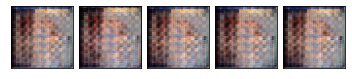

--- EPOCH 100/100 ---
100%|█████████████████████████████████████████| 133/133 [00:29<00:00,  4.58it/s]
Discriminator loss: 0.9627878035145595
Generator loss:     1.8369095029687523


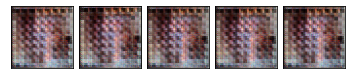

In [58]:
import IPython.display
import tqdm
from hw4.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device,)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


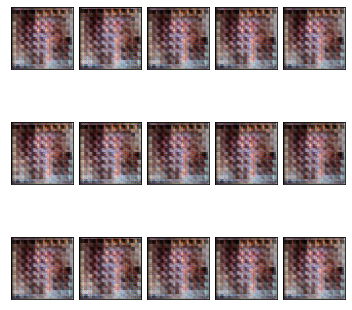

In [59]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw4/answers.py`.

In [ ]:
from cs236781.answers import display_answer
import hw4.answers as answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [ ]:
display_answer(answers.part3_q1)

### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [ ]:
display_answer(answers.part3_q2)

### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [ ]:
display_answer(answers.part3_q3)